In [24]:
# Import libraries
import pandas as pd
import math
import numpy as np
import zipfile

# Import libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set time period for prediction model
from datetime import datetime
start_date = datetime(2020, 11, 1, 0, 0)
end_date = datetime(2023, 8, 31, 23, 59)

In [25]:
# Read relevant csv-files with cleaned bike-trips from zip-file:
df = pd.DataFrame
zf = zipfile.ZipFile('data/trips.zip')
trips_list = ['trips_2020.csv', 'trips_2021.csv', 'trips_2022.csv', 'trips_2023.csv']

for i in range(0, len(trips_list)):
    if i == 0:
        df = pd.read_csv(zf.open(trips_list[i]), low_memory=False)
    else:
        df_temp = pd.read_csv(zf.open(trips_list[i]), low_memory=False)
        df = pd.concat([df, df_temp])
del trips_list
# Cleanup DataFrame
df.drop(columns=['Unnamed: 0', 'start_station_name', 'start_station_lat', 'start_station_lon', 'end_station_name', 'end_station_lat', 'end_station_lon'], inplace=True)
df['starttime'] = pd.to_datetime(df['starttime'], yearfirst=True)

df_temp = df[(df['starttime'] >= start_date) & (df['starttime'] <= end_date)]
df_temp.reset_index(drop=True, inplace=True)
df = df_temp
del df_temp
# Show content of DataFrame
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13332777 entries, 0 to 13332776
Data columns (total 4 columns):
 #   Column               Non-Null Count     Dtype         
---  ------               --------------     -----         
 0   starttime            13332777 non-null  datetime64[ns]
 1   tripduration_in_min  13332777 non-null  float64       
 2   customer             13332777 non-null  object        
 3   rideable_type        13332777 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 406.9+ MB


In [26]:
# Create column with full hours datetime
df['year'] = df['starttime'].dt.year
df['month'] = df['starttime'].dt.month
df['day'] = df['starttime'].dt.day
df['hour'] = df['starttime'].dt.hour
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], format='%Y-%m-%d %H:00')
df.drop(columns=['year', 'month', 'day'], inplace=True)
# Create column rides_count
df_agg = df.groupby(['datetime'])[['tripduration_in_min']].count()
df_agg.rename(columns={'tripduration_in_min': 'rides_count'}, inplace=True)
df_agg.reset_index(drop=False, inplace=True)
# Create columns with customers and bike_types
df_types = df
df_types['casuals'] = np.where(df_types['customer'] == 'casual', 1, 0)
df_types['members'] = np.where(df_types['customer'] == 'member', 1, 0)
df_types['docked_bikes'] = np.where(df_types['rideable_type'] == 'docked_bike', 1, 0)
df_types['classic_bikes'] = np.where(df_types['rideable_type'] == 'classic_bike', 1, 0)
df_types['electric_bikes'] = np.where(df_types['rideable_type'] == 'electric_bike', 1, 0)
df_types_sum = df_types.groupby(['datetime'])[['casuals', 'members', 'docked_bikes', 'classic_bikes', 'electric_bikes']].sum()
df_types_sum.reset_index(drop=False, inplace=True)
df_types_sum
# Merge DataFrames
df_trips = df_agg.merge(df_types_sum, how='left', on='datetime')
del df_agg
del df_types
del df_types_sum
df_trips.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24791 entries, 0 to 24790
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        24791 non-null  datetime64[ns]
 1   rides_count     24791 non-null  int64         
 2   casuals         24791 non-null  int32         
 3   members         24791 non-null  int32         
 4   docked_bikes    24791 non-null  int32         
 5   classic_bikes   24791 non-null  int32         
 6   electric_bikes  24791 non-null  int32         
dtypes: datetime64[ns](1), int32(5), int64(1)
memory usage: 871.7 KB


In [27]:
# Create weather DataFrame
df_weather = pd.read_csv('data/chicago_weather.csv')
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather = df_weather[(df_weather['datetime'] >= start_date) & (df_weather['datetime'] <= end_date)]
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24813 entries, 64409 to 89221
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         24813 non-null  datetime64[ns]
 1   temp             24813 non-null  float64       
 2   rain_1h          24813 non-null  float64       
 3   snow_1h          24813 non-null  float64       
 4   wind_deg         24813 non-null  int64         
 5   wind_speed_km_h  24813 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 1.3 MB


In [28]:
# Merge hourly trips with weather
df_full = df_weather.merge(df_trips, how='left', on='datetime')
df_full['rides_count'].fillna(0, inplace=True)
df_full['casuals'].fillna(0, inplace=True)
df_full['members'].fillna(0, inplace=True)
df_full['docked_bikes'].fillna(0, inplace=True)
df_full['classic_bikes'].fillna(0, inplace=True)
df_full['electric_bikes'].fillna(0, inplace=True)
df_full['hour'] = df_full['datetime'].dt.hour
df_full['dayofweek'] = df_full['datetime'].dt.dayofweek
df_temp = df_full
del df_full
df_temp.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24813 entries, 0 to 24812
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         24813 non-null  datetime64[ns]
 1   temp             24813 non-null  float64       
 2   rain_1h          24813 non-null  float64       
 3   snow_1h          24813 non-null  float64       
 4   wind_deg         24813 non-null  int64         
 5   wind_speed_km_h  24813 non-null  float64       
 6   rides_count      24813 non-null  float64       
 7   casuals          24813 non-null  float64       
 8   members          24813 non-null  float64       
 9   docked_bikes     24813 non-null  float64       
 10  classic_bikes    24813 non-null  float64       
 11  electric_bikes   24813 non-null  float64       
 12  hour             24813 non-null  int32         
 13  dayofweek        24813 non-null  int32         
dtypes: datetime64[ns](1), float64(10), int

### Function for checking for holidays: ###

In [29]:
# Check for national US holidays. If the day is a holiday the function returns True
def is_holiday(date):
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start='2020-01-01', end='2023-12-31')
    return date in holidays

In [30]:
# Create Sub-DataFrames for dry weather, rain and snow
df_no_precipitation = df_temp[(df_temp['rain_1h'] <= 0.25) & (df_temp['snow_1h'] == 0)]
df_light_rain = df_temp[(df_temp['rain_1h'] > 0.25) & (df_temp['rain_1h'] <= 0.75) & (df_temp['snow_1h'] == 0)]
df_moderate_rain = df_temp[(df_temp['rain_1h'] > 0.75) & (df_temp['rain_1h'] <= 1.5) & (df_temp['snow_1h'] == 0)]
df_heavy_rain = df_temp[(df_temp['rain_1h'] > 1.5) & (df_temp['rain_1h'] <= 3) & (df_temp['snow_1h'] == 0)]
df_very_heavy_rain = df_temp[(df_temp['rain_1h'] > 3) & (df_temp['snow_1h'] == 0)]
df_light_snow = df_temp[(df_temp['snow_1h'] > 0) & (df_temp['snow_1h'] <= 0.25)]
df_moderate_snow = df_temp[(df_temp['snow_1h'] > 0.25) & (df_temp['snow_1h'] <= 0.5)]
df_heavy_snow = df_temp[(df_temp['snow_1h'] > 0.5)] # 167 entries

In [31]:
# Function to create hourly, average ride_counts for specific temperature ranges
# separated by working-days (Mon-Fri) and workday-days (Sat-Sun) / holidays
def conditions_rides(df, days: str):
    # Filtering:
    if days == 'workdays':
        df_range = df[(df['dayofweek'] <= 4)]
    else:
        df_range = df[(df['dayofweek'] > 4)]
    # Create empty DataFRame with column 'hour'
    hour_list = []
    for i in range(24):
        hour_list.append(i)
    df_hours = pd.DataFrame(hour_list)
    df_hours.rename(columns = {0: 'hour'}, inplace=True)
    # Creating temperature chunk < -15°C:
    df_temp_range = df_range[(df_range['temp'] < -15)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_<-15'}, inplace=True)
    df_grouped = df_hours.merge(df_temp_grouped, on='hour', how='left')
    # Creating temperature chunk >= -15°C and < -10°C:
    df_temp_range = df_range[(df_range['temp'] >= -15) & (df_range['temp'] < -10)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_-15_-10'}, inplace=True)
    df_grouped = df_grouped.merge(df_temp_grouped, on='hour', how='left')
    # Creating temperature chunk >= -10°C and < -5°C:
    df_temp_range = df_range[(df_range['temp'] >= -10) & (df_range['temp'] < -5)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_-10_-5'}, inplace=True)
    df_grouped = df_grouped.merge(df_temp_grouped, on='hour', how='left')
    # Creating temperature chunk >= -5°C and < 0°C:
    df_temp_range = df_range[(df_range['temp'] >= -5) & (df_range['temp'] < 0)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_-5_0'}, inplace=True)
    df_grouped = df_grouped.merge(df_temp_grouped, on='hour', how='left')
    # Creating temperature chunk >= 0°C and < 5°C:
    df_temp_range = df_range[(df_range['temp'] >= 0) & (df_range['temp'] < 5)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_0_5'}, inplace=True)
    df_grouped = df_grouped.merge(df_temp_grouped, on='hour', how='left')
    # Creating temperature chunk >= 5°C and < 10°C:
    df_temp_range = df_range[(df_range['temp'] >= 5) & (df_range['temp'] < 10)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_5_10'}, inplace=True)
    df_grouped = df_grouped.merge(df_temp_grouped, on='hour', how='left')
    # Creating temperature chunk >= 10°C and < 15°C:
    df_temp_range = df_range[(df_range['temp'] >= 10) & (df_range['temp'] < 15)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_10_15'}, inplace=True)
    df_grouped = df_grouped.merge(df_temp_grouped, on='hour', how='left')
    # Creating temperature chunk >= 15°C and < 20°C:
    df_temp_range = df_range[(df_range['temp'] >= 15) & (df_range['temp'] < 20)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_15_20'}, inplace=True)
    df_grouped = df_grouped.merge(df_temp_grouped, on='hour', how='left')
    # Creating temperature chunk >= 20°C:
    df_temp_range = df_range[(df_range['temp'] >= 20)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_>20'}, inplace=True)
    df_grouped = df_grouped.merge(df_temp_grouped, on='hour', how='left')    
    # Interpolate missing values in each row
    #df_grouped = df_grouped.interpolate(method='polynomial', order=2, axis=0)
    df_grouped = df_grouped.interpolate(method='linear', axis=0)
    # Change columns data to integer
    df_grouped['rides_<-15'] = round(df_grouped['rides_<-15'], 0)
    df_grouped['rides_-15_-10'] = round(df_grouped['rides_-15_-10'], 0)
    df_grouped['rides_-10_-5'] = round(df_grouped['rides_-10_-5'], 0)
    df_grouped['rides_-5_0'] = round(df_grouped['rides_-5_0'], 0)
    df_grouped['rides_0_5'] = round(df_grouped['rides_0_5'], 0)
    df_grouped['rides_5_10'] = round(df_grouped['rides_5_10'], 0)
    df_grouped['rides_10_15'] = round(df_grouped['rides_10_15'], 0)
    df_grouped['rides_15_20'] = round(df_grouped['rides_15_20'], 0)
    df_grouped['rides_>20'] = round(df_grouped['rides_>20'], 0)

    return df_grouped

In [32]:
df_no_prec_workday = conditions_rides(df_no_precipitation, 'workdays')
df_no_prec_weekend = conditions_rides(df_no_precipitation, 'weekend')
df_light_rain_workday = conditions_rides(df_light_rain, 'workdays')
df_light_rain_weekend = conditions_rides(df_light_rain, 'weekend')
df_moderate_rain_workday = conditions_rides(df_moderate_rain, 'workdays')
df_moderate_rain_weekend = conditions_rides(df_moderate_rain, 'weekend')
df_heavy_rain_workday = conditions_rides(df_heavy_rain, 'workdays')
df_heavy_rain_weekend = conditions_rides(df_heavy_rain, 'weekend')
df_very_heavy_rain_workday = conditions_rides(df_very_heavy_rain, 'workdays')
df_very_heavy_rain_weekend = conditions_rides(df_very_heavy_rain, 'weekend')
df_light_snow_workday = conditions_rides(df_light_snow, 'workdays')
df_light_snow_weekend = conditions_rides(df_light_snow, 'weekend')
df_moderate_snow_workday = conditions_rides(df_moderate_snow, 'workdays')
df_moderate_snow_weekend = conditions_rides(df_moderate_snow, 'weekend')
df_heavy_snow_workday = conditions_rides(df_heavy_snow, 'workdays')
df_heavy_snow_weekend = conditions_rides(df_heavy_snow, 'weekend')

In [33]:
# Show DataFrames
df_no_prec_workday
#df_no_prec_weekend
#df_light_rain_workday
#df_light_rain_weekend
#df_moderate_rain_workday
#df_moderate_rain_weekend
#df_heavy_rain_workday
#df_heavy_rain_weekend
#df_very_heavy_rain_workday
#df_very_heavy_rain_weekend
#df_light_snow_workday
#df_light_snow_weekend
#df_moderate_snow_workday
#df_moderate_snow_weekend
#df_heavy_snow_workday
#df_heavy_snow_weekend

,hour,rides_<-15,rides_-15_-10,rides_-10_-5,rides_-5_0,rides_0_5,rides_5_10,rides_10_15,rides_15_20,rides_>20
0,0,4.0,12.0,18.0,28.0,41.0,72.0,111.0,163.0,231.0
1,1,3.0,6.0,10.0,16.0,23.0,41.0,66.0,92.0,129.0
2,2,2.0,5.0,6.0,11.0,15.0,23.0,38.0,54.0,78.0
3,3,2.0,5.0,5.0,8.0,12.0,17.0,26.0,36.0,50.0
4,4,5.0,7.0,11.0,14.0,19.0,25.0,34.0,48.0,57.0
5,5,22.0,35.0,40.0,61.0,76.0,100.0,134.0,176.0,190.0
6,6,55.0,71.0,114.0,166.0,217.0,286.0,396.0,523.0,555.0
7,7,84.0,123.0,207.0,304.0,410.0,571.0,762.0,920.0,974.0
8,8,102.0,119.0,245.0,349.0,488.0,625.0,875.0,1019.0,1125.0
9,9,62.0,72.0,145.0,191.0,293.0,386.0,533.0,668.0,752.0


### Prediction of ride_counts for the selected period of time: ###

In [34]:
df_predicted = df_temp
# Add column with predicted_rides per hour
for i, row in df_predicted.iterrows():
    # Values for working days:
    if (row['dayofweek'] <= 4) and (is_holiday(row['datetime'].floor('d')) == False):
        if row['temp'] < -15:
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_workday.at[df_predicted.at[i,'hour'], 'rides_<-15']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_workday.at[df_predicted.at[i,'hour'], 'rides_<-15']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_workday.at[df_predicted.at[i,'hour'], 'rides_<-15']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_<-15']
        elif (row['temp'] >= -15) and (row['temp'] < -10):
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-15_-10']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-15_-10']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-15_-10']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_-15_-10']
        elif (row['temp'] >= -10) and (row['temp'] < -5):
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-10_-5']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-10_-5']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-10_-5']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_-10_-5']
        elif (row['temp'] >= -5) and (row['temp'] < 0):
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-5_0']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-5_0']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-5_0']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_-5_0']
        elif (row['temp'] >= 0) and (row['temp'] < 5):
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_workday.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_workday.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_workday.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_workday.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_workday.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_0_5']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_0_5']
        elif (row['temp'] >= 5) and (row['temp'] < 10):
            if (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_workday.at[df_predicted.at[i,'hour'], 'rides_5_10']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_workday.at[df_predicted.at[i,'hour'], 'rides_5_10']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_5_10']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_5_10']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_5_10']
        elif (row['temp'] >= 10) and (row['temp'] < 15):
            if (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_workday.at[df_predicted.at[i,'hour'], 'rides_10_15']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_workday.at[df_predicted.at[i,'hour'], 'rides_10_15']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_10_15']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_10_15']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_10_15']
        elif (row['temp'] >= 15) and (row['temp'] < 20):
            if (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_workday.at[df_predicted.at[i,'hour'], 'rides_15_20']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_workday.at[df_predicted.at[i,'hour'], 'rides_15_20']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_15_20']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_15_20']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_15_20']
        elif (row['temp'] >= 20):
            if (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_workday.at[df_predicted.at[i,'hour'], 'rides_>20']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_workday.at[df_predicted.at[i,'hour'], 'rides_>20']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_>20']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_>20']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_>20']
    # Values for weekends and holidays
    else:
        if row['temp'] < -15:
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_<-15']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_<-15']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_<-15']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_<-15']
        elif (row['temp'] >= -15) and (row['temp'] < -10):
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-15_-10']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-15_-10']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-15_-10']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_-15_-10']
        elif (row['temp'] >= -10) and (row['temp'] < -5):
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-10_-5']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-10_-5']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-10_-5']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_-10_-5']
        elif (row['temp'] >= -5) and (row['temp'] < 0):
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-5_0']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-5_0']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-5_0']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_-5_0']
        elif (row['temp'] >= 0) and (row['temp'] < 5):
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_0_5']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_0_5']
        elif (row['temp'] >= 5) and (row['temp'] < 10):
            if (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_5_10']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_5_10']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_5_10']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_5_10']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_5_10']
        elif (row['temp'] >= 10) and (row['temp'] < 15):
            if (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_10_15']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_10_15']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_10_15']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_10_15']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_10_15']
        elif (row['temp'] >= 15) and (row['temp'] < 20):
            if (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_15_20']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_15_20']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_15_20']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_15_20']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_15_20']
        elif (row['temp'] >= 20):
            if (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_>20']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_>20']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_>20']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_>20']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_>20']
df_predicted.drop(columns=['hour', 'dayofweek'], inplace=True)
df_predicted.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24813 entries, 0 to 24812
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         24813 non-null  datetime64[ns]
 1   temp             24813 non-null  float64       
 2   rain_1h          24813 non-null  float64       
 3   snow_1h          24813 non-null  float64       
 4   wind_deg         24813 non-null  int64         
 5   wind_speed_km_h  24813 non-null  float64       
 6   rides_count      24813 non-null  float64       
 7   casuals          24813 non-null  float64       
 8   members          24813 non-null  float64       
 9   docked_bikes     24813 non-null  float64       
 10  classic_bikes    24813 non-null  float64       
 11  electric_bikes   24813 non-null  float64       
 12  predicted_rides  24799 non-null  float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 2.5 MB


In [35]:
# Few predicted_rides have null-values which will be corrected here:
df_predicted['predicted_rides'].fillna(df_predicted['rides_count'], inplace=True)
df_predicted['predicted_rides'] = df_predicted['predicted_rides'].astype(int)
df_predicted.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24813 entries, 0 to 24812
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         24813 non-null  datetime64[ns]
 1   temp             24813 non-null  float64       
 2   rain_1h          24813 non-null  float64       
 3   snow_1h          24813 non-null  float64       
 4   wind_deg         24813 non-null  int64         
 5   wind_speed_km_h  24813 non-null  float64       
 6   rides_count      24813 non-null  float64       
 7   casuals          24813 non-null  float64       
 8   members          24813 non-null  float64       
 9   docked_bikes     24813 non-null  float64       
 10  classic_bikes    24813 non-null  float64       
 11  electric_bikes   24813 non-null  float64       
 12  predicted_rides  24813 non-null  int32         
dtypes: datetime64[ns](1), float64(10), int32(1), int64(1)
memory usage: 2.4 MB


### Plot trips (real/predicted) and rain/snow (if occured) for specified weeks: ###

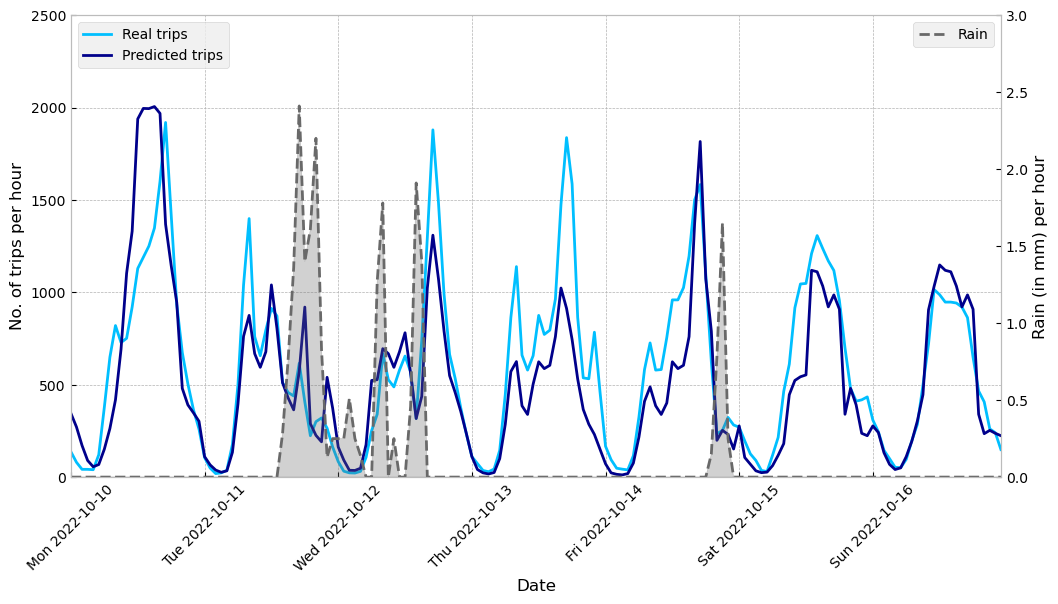

In [36]:
# Plot temperature and rain/snow (if occured):
# Good examples summer + dry weather: '2021-06-03', '2022-06-30', '2022-07-21', '2022-07-28', '2022-08-25'
# Good examples summer + precipitation: '2021-06-10', '2021-07-01', '2022-08-18', '2023-06-15', '2023-06-30'

# Good examples autumn + dry weather: '2021-09-16', '2022-09-22', '2022-10-20', '2022-11-10'
# Good examples autumn + precipitation: '2021-09-08', '2022-09-09', '2022-10-27'

# Good examples winter + dry weather: '2022-03-03', '2023-01-12'
# Good examples winter + precipitation: '2022-12-08', '2023-02-09'

# Good examples sprint + dry weather: '2022-03-03', '2022-05-12'
# Good examples sprint + precipitation: '2022-03-17', 2022-04-21', '2023-03-08'
from datetime import datetime, timedelta

#date_str = '2022-10-20' # Almost no rain
date_str = '2022-10-13' # with rain

# Build start and end date of whole week 
date_obj = datetime.strptime(date_str, '%Y-%m-%d')
start_of_week = date_obj - timedelta(days=date_obj.weekday())  # Monday
end_of_week = start_of_week + timedelta(days=6, hours=23, minutes= 59)  # Sunday

# Build DataFrame with full week:
df_print = df_predicted[(df_predicted['datetime'] >= start_of_week) & (df_predicted['datetime'] <= end_of_week)]
df_print.reset_index(drop=True, inplace=True)
#df_print

# Plot DataFrame with whole week
plt.style.use('bmh')
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_facecolor('white')

# Set real and predicted rides for main axis
real_rides = ax1.plot(df_print['datetime'], df_print['rides_count'], color='deepskyblue', linestyle='-')
predicted_rides = ax1.plot(df_print['datetime'], df_print['predicted_rides'], color='darkblue', linestyle='-')
ax1.set_ylabel('No. of trips per hour')
# Set predicted rides y-axis according to values in 500 rides intervals
if df_print['rides_count'].max() > df_print['predicted_rides'].max():
    rides_max = (math.ceil(df_print['rides_count'].max()) // 500 + 1) * 500
else:
    rides_max = (math.ceil(df_print['predicted_rides'].max()) // 500 + 1) * 500
ax1.set_ylim(0, rides_max)
# Set datetime x-axis with day intervals
ax1.set_xlabel('Date')
ax1.set_xlim(df_print['datetime'].min(), df_print['datetime'].max())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%a %Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator())
#ax1.legend(['No. of trips per hour'], loc="upper left")
ax1.legend(['Real trips', 'Predicted trips'], loc="upper left")
#ax1.legend(['No. of real trips per hour', 'No. of predicted trips per hour'], loc="upper left")
plt.xticks(rotation=45, fontweight='light')

# Set secondary y-axis with rain/snow if existent
if (df_print['rain_1h'].max() > 0) or (df_print['snow_1h'].max() > 0):
    ax2 = ax1.twinx()
    if (df_print['rain_1h'].max() > 0) and (df_print['snow_1h'].max() == 0):
        ax2.set_ylabel('Rain (in mm) per hour')#, color='white')
        ax2.set_ylim(0, math.ceil(df_print['rain_1h'].max()))
        rain = ax2.plot(df_print['datetime'], df_print['rain_1h'], color='dimgrey', linestyle='--')
        #ax2.set_yticks(ticks=[1,2,3,4,5], labels=['1','2','3','4','5'], minor=False, color='white')
        #ax2.tick_params(color='white')
        ax2.legend(['Rain'], loc="upper right")
    elif (df_print['rain_1h'].max() == 0) and (df_print['snow_1h'].max() > 0):
        ax2.set_ylabel('Snow (in mm) per hour')
        ax2.set_ylim(0, math.ceil(df_print['snow_1h'].max()))
        snow = ax2.plot(df_print['datetime'], df_print['snow_1h'], color='greenyellow')
        ax2.legend(['Snow'], loc="upper right")
    else:
        ax2.set_ylabel('Precipitation (in mm) per hour')
        rain = ax2.plot(df_print['datetime'], df_print['rain_1h'], color='dimgrey', linestyle='--')
        snow = ax2.plot(df_print['datetime'], df_print['snow_1h'], color='greenyellow')
        if df_print['rain_1h'].max() > df_print['snow_1h'].max() > 0:
            ax2.set_ylim(0, math.ceil(df_print['rain_1h'].max()))
        else:
            ax2.set_ylim(0, math.ceil(df_print['snow_1h'].max()))
        ax2.legend(['Rain', 'Snow'], loc="upper right")
    
    ax2.grid(False)
    plt.fill_between(df_predicted['datetime'], df_predicted['rain_1h'], color='dimgrey', alpha=0.3)

# Show diagram
plt.show();